## Notebook Roadmap
1. Configuration and shared styling
2. Data inputs and respondent coverage checks
3. Respondent-level PSD extraction and 500 ms binning
4. Pairwise sliding-window correlation helpers
5. Aggregation of ISC traces and caching
6. Short vs Long visualisation overlays
7. Statistical summaries (Part 1 & Part 2)
8. Diagnostics, issues log, and exports

In [21]:
from __future__ import annotations

import importlib
from pathlib import Path
from textwrap import dedent
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import wbdlib
import wbdlib.timeseries as _wbd_ts
importlib.reload(_wbd_ts)
importlib.reload(wbdlib)

from wbdlib import (
    COLOR_MAP,
    aggregate_binned_time_series,
    bin_time_series,
    build_stimulus_lookup,
    canonicalise_title,
    default_metric_columns,
    default_time_series_processing_config,
    get_key_moment_window,
    load_key_moments,
    load_stimulus_map,
    process_sensor_time_series,
    resolve_stimulus_identity,
)
from wbdlib.imotions import read_imotions
from wbdlib.plotting import register_boxplot_with_means

# Notebook metadata
title = "EEG Inter-Subject Correlation"
description = dedent(
    """
    Compute sliding-window inter-subject correlations for EEG PSD clusters,
    mirroring the biometric pipelines.
    """
)

# Styling mirrors the enjoyment and biometric notebooks for consistency.
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["font.family"] = "Century Gothic"
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams.update({"font.size": 10, "axes.titleweight": "bold"})
register_boxplot_with_means()

PALETTE = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
DEFAULT_FIGSIZE = (10, 4)
NOTEBOOK_ROOT = Path.cwd()

# Paths
PROJECT_ROOT = NOTEBOOK_ROOT.parent
DATA_EXPORT_DIR = PROJECT_ROOT / "data" / "Export"
CACHE_DIR = PROJECT_ROOT / "results" / "time_series_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Target EEG PSD columns expected at 2 Hz; cadence will be verified downstream.
PSD_CLUSTER_COLUMNS = [
    "EEG_PSD_ElectrodeClusterAverageDeltadB",
    "EEG_PSD_ElectrodeClusterAverageThetadB",
    "EEG_PSD_ElectrodeClusterAverageAlphadB",
    "EEG_PSD_ElectrodeClusterAverageBetadB",
    "EEG_PSD_ElectrodeClusterAverageGammadB",
]
PSD_BIN_SECONDS = 0.5
WINDOW_SAMPLES = 5  # 5 samples * 500 ms = 2.5 s windows
WINDOW_OVERLAP = 0.5  # 50% overlap


def normalise_psd_name(name: str) -> str:
    return "".join(ch.lower() for ch in name if ch.isalnum())


PSD_COLUMN_ALIASES: dict[str, list[str]] = {}
for canonical in PSD_CLUSTER_COLUMNS:
    band_label = (
        canonical.replace("EEG_PSD_ElectrodeClusterAverage", "").replace("dB", "")
    )
    pretty_label = band_label.title()
    PSD_COLUMN_ALIASES[canonical] = [
        f"Electrode Cluster Average {pretty_label} (dB)",
        f"Electrode Cluster Average {pretty_label} (absolute unit)",
    ]


PSD_CANONICAL_LOOKUP: dict[str, str] = {}
for canonical in PSD_CLUSTER_COLUMNS:
    PSD_CANONICAL_LOOKUP[normalise_psd_name(canonical)] = canonical
    for alias in PSD_COLUMN_ALIASES.get(canonical, []):
        PSD_CANONICAL_LOOKUP[normalise_psd_name(alias)] = canonical
    stripped = (
        canonical.replace("EEG_PSD_", "")
        .replace("ElectrodeClusterAverage", "")
        .replace("_", "")
    )
    PSD_CANONICAL_LOOKUP.setdefault(normalise_psd_name(stripped), canonical
)


def map_psd_columns(columns: Iterable[str]) -> dict[str, str]:
    mapping: dict[str, str] = {}
    for col in columns:
        key = normalise_psd_name(col)
        canonical = PSD_CANONICAL_LOOKUP.get(key)
        if canonical and canonical not in mapping:
            mapping[canonical] = col
    return mapping


def first_available(columns: Iterable[str], candidates: Iterable[str]) -> str | None:
    for candidate in candidates:
        if candidate in columns:
            return candidate
    return None


def resolve_sensor_columns(
    columns: Iterable[str],
) -> tuple[str | None, str | None, str | None, dict[str, str]]:
    column_list = list(columns)
    timestamp_column: str | None = None
    timestamp_candidates = [
        col for col in column_list if "timestamp" in col.lower()
    ]
    for candidate in timestamp_candidates:
        if "synchronization" in candidate.lower():
            timestamp_column = candidate
            break
    if timestamp_column is None and timestamp_candidates:
        timestamp_column = timestamp_candidates[0]

    stimulus_column = first_available(
        column_list, ["SE_SourceStimuliName", "SourceStimuliName"]
    )
    event_column = first_available(
        column_list, ["SE_SlideEvent", "SlideEvent"]
    )
    psd_mapping = map_psd_columns(column_list)
    return timestamp_column, stimulus_column, event_column, psd_mapping

## Sampling PSD Cadence
Inspect a random subset of respondents with valid EEG data to verify the timestamp cadence present in the raw exports.

In [11]:
RANDOM_SEED = 42
uv_stage1_path = PROJECT_ROOT / "results" / "uv_stage1.csv"
sensor_metadata_path = CACHE_DIR / "sensor_metadata.csv"
if not uv_stage1_path.exists():
    raise FileNotFoundError(f"Missing respondent roster at {uv_stage1_path}")
uv_stage1 = pd.read_csv(uv_stage1_path)
sensor_metadata = pd.read_csv(sensor_metadata_path) if sensor_metadata_path.exists() else pd.DataFrame()
if sensor_metadata.empty:
    raise FileNotFoundError(
        "Expected sensor_metadata.csv generated by time-series pipeline is missing."
    )
uv_stage1["grid_comments"] = uv_stage1["grid_comments"].fillna("")
has_eeg_mask = ~uv_stage1["grid_comments"].str.contains("No EEG", case=False)
uv_stage1_eeg = uv_stage1.loc[has_eeg_mask].copy()
meta_subset = sensor_metadata.merge(
    uv_stage1_eeg[["respondent", "group", "source_file"]],
    left_on="respondent_id",
    right_on="respondent",
    how="inner",
    suffixes=("", "_uv"),
)
if meta_subset.empty:
    raise RuntimeError("No respondents with EEG metadata available for inspection.")
sampled_meta = meta_subset.sample(n=min(3, len(meta_subset)), random_state=RANDOM_SEED)
cadence_summary = []
preview_frames = {}
header_catalog = {}


def locate_header_line(
    csv_path: Path,
    token: str = "iMotions_Synchronization_Timestamp",
    max_lines: int = 500,
) -> int | None:
    with csv_path.open("r", encoding="utf-8-sig", errors="ignore") as handle:
        for idx, line in enumerate(handle):
            if token in line:
                return idx
            if idx >= max_lines:
                break
    return None


def read_sensor_columns(csv_path: Path) -> pd.Index:
    frame, _ = read_imotions(
        csv_path,
        nrows=0,
        engine="python",
        on_bad_lines="skip",
    )
    return frame.columns


def load_sensor_sample(
    csv_path: Path,
    *,
    usecols: Iterable[str] | None = None,
    nrows: int | None = None,
) -> pd.DataFrame:
    kwargs: dict[str, object] = {"engine": "python", "on_bad_lines": "skip"}
    if usecols is not None:
        kwargs["usecols"] = usecols
    if nrows is not None:
        kwargs["nrows"] = nrows
    frame, _ = read_imotions(csv_path, **kwargs)
    return frame


for _, row in sampled_meta.iterrows():
    respondent_id = int(row["respondent_id"])
    source_path = Path(row["source_path"])
    if not source_path.exists():
        cadence_summary.append({
            "respondent_id": respondent_id,
            "note": "sensor file missing",
        })
        continue

    header_idx = locate_header_line(source_path)
    try:
        header_columns = read_sensor_columns(source_path)
    except Exception as exc:
        cadence_summary.append(
            {
                "respondent_id": respondent_id,
                "note": f"failed to read columns ({exc})",
            }
        )
        continue

    header_catalog[respondent_id] = header_columns[:15].tolist()
    timestamp_column, stimulus_column, event_column, psd_mapping = resolve_sensor_columns(
        header_columns
    )
    if not timestamp_column:
        cadence_summary.append(
            {
                "respondent_id": respondent_id,
                "note": "timestamp column not detected",
            }
        )
        continue

    sample_usecols: list[str] = [timestamp_column]
    if psd_mapping:
        sample_usecols.extend(psd_mapping.values())

    try:
        raw_slice = load_sensor_sample(
            source_path,
            usecols=sample_usecols,
            nrows=200,
        )
    except ValueError:
        raw_slice = load_sensor_sample(
            source_path,
            usecols=[timestamp_column],
            nrows=200,
        )

    rename_map = {timestamp_column: "timestamp_ms"}
    raw_slice = raw_slice.rename(columns=rename_map)
    raw_slice["timestamp_ms"] = pd.to_numeric(
        raw_slice["timestamp_ms"], errors="coerce"
    )
    raw_slice = raw_slice.dropna(subset=["timestamp_ms"])
    raw_slice["delta_ms"] = raw_slice["timestamp_ms"].diff()
    deltas = raw_slice["delta_ms"].dropna()

    cadence_summary.append(
        {
            "respondent_id": respondent_id,
            "source_path": str(source_path),
            "timestamp_column": timestamp_column,
            "header_row": header_idx,
            "rows_inspected": int(len(raw_slice)),
            "delta_ms_median": float(deltas.median()) if not deltas.empty else np.nan,
            "delta_ms_mode": float(deltas.mode().iloc[0]) if not deltas.empty else np.nan,
            "delta_ms_unique": ", ".join(sorted({f"{val:.3f}" for val in deltas.unique()})),
            "psd_columns_detected": ", ".join(sorted(psd_mapping.keys())),
        }
    )

    preview_frames[respondent_id] = raw_slice.head(10)

cadence_df = pd.DataFrame(cadence_summary)
display(cadence_df)
for respondent_id, frame in preview_frames.items():
    print(f"\nRespondent {respondent_id} preview")
    display(frame[["timestamp_ms", "delta_ms"]])
if header_catalog:
    print("\nColumn name preview (first 15 columns):")
    for respondent_id, columns in header_catalog.items():
        print(f"Respondent {respondent_id}: {columns}")

,respondent_id,source_path,timestamp_column,header_row,rows_inspected,delta_ms_median,delta_ms_mode,delta_ms_unique,psd_columns_detected
0,36,c:\Users\ashra\Documents\NeuralSense\NeuralDat...,Timestamp,29,200,5.0,8.0,"1.000, 2.000, 3.000, 4.000, 5.000, 6.000, 7.00...","EEG_PSD_ElectrodeClusterAverageAlphadB, EEG_PS..."
1,90,c:\Users\ashra\Documents\NeuralSense\NeuralDat...,Timestamp,29,200,5.0,8.0,"1.000, 2.000, 3.000, 4.000, 5.000, 6.000, 7.00...","EEG_PSD_ElectrodeClusterAverageAlphadB, EEG_PS..."
2,55,c:\Users\ashra\Documents\NeuralSense\NeuralDat...,Timestamp,29,200,5.0,8.0,"1.000, 2.000, 3.000, 4.000, 5.000, 6.000, 7.00...","EEG_PSD_ElectrodeClusterAverageAlphadB, EEG_PS..."



Respondent 36 preview


,timestamp_ms,delta_ms
0,35297,NaN
1,35298,1.0
2,35302,4.0
3,35303,1.0
4,35310,7.0
5,35314,4.0
6,35317,3.0
7,35325,8.0
8,35331,6.0
9,35333,2.0



Respondent 90 preview


,timestamp_ms,delta_ms
0,35312,NaN
1,35316,4.0
2,35324,8.0
3,35329,5.0
4,35332,3.0
5,35333,1.0
6,35340,7.0
7,35346,6.0
8,35348,2.0
9,35356,8.0



Respondent 55 preview


,timestamp_ms,delta_ms
0,37454,NaN
1,37456,2.0
2,37457,1.0
3,37465,8.0
4,37472,7.0
5,37473,1.0
6,37476,3.0
7,37480,4.0
8,37488,8.0
9,37489,1.0



Column name preview (first 15 columns):
Respondent 36: ['Row', 'Timestamp', 'EventSource', 'SlideEvent', 'StimType', 'Duration', 'CollectionPhase', 'SourceStimuliName', 'EventSource.1', 'Epoch', 'Hour', 'Min', 'Sec', 'Milli', 'Classification']
Respondent 90: ['Row', 'Timestamp', 'EventSource', 'SlideEvent', 'StimType', 'Duration', 'CollectionPhase', 'SourceStimuliName', 'EventSource.1', 'Epoch', 'Hour', 'Min', 'Sec', 'Milli', 'Classification']
Respondent 55: ['Row', 'Timestamp', 'EventSource', 'SlideEvent', 'StimType', 'Duration', 'CollectionPhase', 'SourceStimuliName', 'EventSource.1', 'Epoch', 'Hour', 'Min', 'Sec', 'Milli', 'Classification']


### PSD Column Cadence
Quantify cadence and non-missing density for the PSD metrics to confirm whether they align with the timestamp cadence.

In [12]:
psd_cadence_records: list[dict[str, object]] = []
for _, summary_row in cadence_df.dropna(subset=["source_path"]).iterrows():
    respondent_id = int(summary_row["respondent_id"])
    source_path = Path(summary_row["source_path"])
    if not source_path.exists():
        psd_cadence_records.append(
            {
                "respondent_id": respondent_id,
                "column": "<missing>",
                "note": "sensor file missing",
            }
        )
        continue

    try:
        header_columns = read_sensor_columns(source_path)
    except Exception as exc:
        psd_cadence_records.append(
            {
                "respondent_id": respondent_id,
                "column": "<missing>",
                "note": f"failed to read columns ({exc})",
            }
        )
        continue

    timestamp_column = summary_row.get("timestamp_column")
    if not timestamp_column or timestamp_column not in header_columns:
        psd_cadence_records.append(
            {
                "respondent_id": respondent_id,
                "column": "<missing>",
                "note": "timestamp column unavailable for PSD cadence",
            }
        )
        continue

    _, _, _, psd_mapping = resolve_sensor_columns(header_columns)
    if not psd_mapping:
        psd_cadence_records.append(
            {
                "respondent_id": respondent_id,
                "column": "<none>",
                "note": "no PSD columns detected",
            }
        )
        continue

    sample_usecols = [timestamp_column, *psd_mapping.values()]
    try:
        frame = load_sensor_sample(
            source_path,
            usecols=sample_usecols,
            nrows=2000,
        )
    except ValueError:
        frame = load_sensor_sample(
            source_path,
            usecols=[timestamp_column],
            nrows=2000,
        )

    rename_map = {timestamp_column: "timestamp_ms"}
    rename_map.update({actual: canonical for canonical, actual in psd_mapping.items()})
    frame = frame.rename(columns=rename_map)
    frame["timestamp_ms"] = pd.to_numeric(frame["timestamp_ms"], errors="coerce")
    frame = frame.dropna(subset=["timestamp_ms"])
    if frame.empty:
        psd_cadence_records.append(
            {
                "respondent_id": respondent_id,
                "column": "<none>",
                "note": "no timestamp rows after coercion",
            }
        )
        continue

    rows_inspected = int(frame.shape[0])
    for canonical_name in psd_mapping.keys():
        if canonical_name not in frame.columns:
            continue
        values = pd.to_numeric(frame[canonical_name], errors="coerce")
        non_na_mask = values.notna()
        non_na_count = int(non_na_mask.sum())
        if non_na_count == 0:
            psd_cadence_records.append(
                {
                    "respondent_id": respondent_id,
                    "column": canonical_name,
                    "rows_inspected": rows_inspected,
                    "non_na_count": 0,
                    "non_na_ratio": 0.0,
                    "delta_ms_median": np.nan,
                    "delta_ms_mode": np.nan,
                    "delta_ms_unique": "",
                }
            )
            continue

        timestamps = frame.loc[non_na_mask, "timestamp_ms"].to_numpy()
        ts_deltas = np.diff(timestamps)
        if ts_deltas.size:
            ts_delta_series = pd.Series(ts_deltas)
            delta_median = float(ts_delta_series.median())
            delta_mode = (
                float(ts_delta_series.mode().iloc[0])
                if not ts_delta_series.mode().empty
                else np.nan
            )
            unique_deltas = ", ".join(sorted({f"{val:.3f}" for val in ts_deltas}))
        else:
            delta_median = np.nan
            delta_mode = np.nan
            unique_deltas = ""

        psd_cadence_records.append(
            {
                "respondent_id": respondent_id,
                "column": canonical_name,
                "rows_inspected": rows_inspected,
                "non_na_count": non_na_count,
                "non_na_ratio": non_na_count / rows_inspected if rows_inspected else np.nan,
                "delta_ms_median": delta_median,
                "delta_ms_mode": delta_mode,
                "delta_ms_unique": unique_deltas,
            }
        )

psd_cadence_df = pd.DataFrame(psd_cadence_records)
if psd_cadence_df.empty:
    display(pd.DataFrame({"note": ["No PSD cadence records generated"]}))
else:
    display(psd_cadence_df)
    metric_columns = {"non_na_ratio", "delta_ms_median", "delta_ms_mode"}
    if metric_columns.issubset(psd_cadence_df.columns):
        metric_rows = psd_cadence_df.dropna(subset=["non_na_ratio"])
        if metric_rows.empty:
            display(
                pd.DataFrame(
                    {
                        "note": [
                            "PSD cadence metrics unavailable for detected columns"
                        ]
                    }
                )
            )
        else:
            psd_summary = (
                metric_rows.groupby("column")
                .agg(
                    {
                        "non_na_ratio": ["mean", "min", "max"],
                        "delta_ms_median": "median",
                        "delta_ms_mode": lambda s: s.mode().iloc[0]
                        if not s.mode().empty
                        else np.nan,
                    }
                )
                .sort_index()
            )
            psd_summary.columns = [
                "_".join(col).rstrip("_")
                for col in psd_summary.columns.to_flat_index()
            ]
            display(psd_summary.reset_index())
    else:
        missing_cols = sorted(metric_columns.difference(psd_cadence_df.columns))
        display(
            pd.DataFrame(
                {
                    "note": ["Skipping PSD cadence summary; missing columns"],
                    "missing": [", ".join(missing_cols)],
                }
            )
        )

,respondent_id,column,rows_inspected,non_na_count,non_na_ratio,delta_ms_median,delta_ms_mode,delta_ms_unique
0,36,EEG_PSD_ElectrodeClusterAverageDeltadB,2000,19,0.0095,500.0,500.0,500.000
1,36,EEG_PSD_ElectrodeClusterAverageThetadB,2000,19,0.0095,500.0,500.0,500.000
2,36,EEG_PSD_ElectrodeClusterAverageAlphadB,2000,19,0.0095,500.0,500.0,500.000
3,36,EEG_PSD_ElectrodeClusterAverageBetadB,2000,19,0.0095,500.0,500.0,500.000
4,36,EEG_PSD_ElectrodeClusterAverageGammadB,2000,19,0.0095,500.0,500.0,500.000
5,90,EEG_PSD_ElectrodeClusterAverageDeltadB,2000,19,0.0095,500.0,500.0,500.000
6,90,EEG_PSD_ElectrodeClusterAverageThetadB,2000,19,0.0095,500.0,500.0,500.000
7,90,EEG_PSD_ElectrodeClusterAverageAlphadB,2000,19,0.0095,500.0,500.0,500.000
8,90,EEG_PSD_ElectrodeClusterAverageBetadB,2000,19,0.0095,500.0,500.0,500.000
9,90,EEG_PSD_ElectrodeClusterAverageGammadB,2000,19,0.0095,500.0,500.0,500.000


,column,non_na_ratio_mean,non_na_ratio_min,non_na_ratio_max,delta_ms_median_median,delta_ms_mode_<lambda>
0,EEG_PSD_ElectrodeClusterAverageAlphadB,0.009667,0.0095,0.01,500.0,500.0
1,EEG_PSD_ElectrodeClusterAverageBetadB,0.009667,0.0095,0.01,500.0,500.0
2,EEG_PSD_ElectrodeClusterAverageDeltadB,0.009667,0.0095,0.01,500.0,500.0
3,EEG_PSD_ElectrodeClusterAverageGammadB,0.009667,0.0095,0.01,500.0,500.0
4,EEG_PSD_ElectrodeClusterAverageThetadB,0.009667,0.0095,0.01,500.0,500.0


In [4]:
sample_path = Path(cadence_df.loc[0, "source_path"])
print(f"Previewing columns for {sample_path.name}")
columns_frame = read_sensor_columns(sample_path)
print(f"Total columns detected: {len(columns_frame)}")
timestamp_column, stimulus_column, event_column, psd_mapping = resolve_sensor_columns(
    columns_frame
)
print(f"Resolved PSD mapping columns: {list(psd_mapping.items())[:5]}")
if not timestamp_column:
    raise RuntimeError("Unable to identify timestamp column for preview sample")

alpha_column = psd_mapping.get("EEG_PSD_ElectrodeClusterAverageAlphadB")
preview_usecols = [timestamp_column]
if stimulus_column:
    preview_usecols.append(stimulus_column)
if event_column:
    preview_usecols.append(event_column)
if alpha_column:
    preview_usecols.append(alpha_column)

preview_frame = load_sensor_sample(
    sample_path,
    usecols=preview_usecols,
    nrows=50,
)
rename_map: dict[str, str] = {timestamp_column: "timestamp_ms"}
if stimulus_column:
    rename_map[stimulus_column] = "stimulus"
if event_column:
    rename_map[event_column] = "event"
if alpha_column:
    rename_map[alpha_column] = "EEG_PSD_ElectrodeClusterAverageAlphadB"
preview_frame = preview_frame.rename(columns=rename_map)
columns_to_show = [
    col
    for col in [
        "timestamp_ms",
        "stimulus",
        "event",
        "EEG_PSD_ElectrodeClusterAverageAlphadB",
    ]
    if col in preview_frame.columns
]
psd_like_columns = [col for col in columns_frame if "psd" in col.lower()]
eeg_like_columns = [col for col in columns_frame if "eeg" in col.lower()]
metric_like_columns = [col for col in columns_frame if "metric" in col.lower()]
cluster_like_columns = [col for col in columns_frame if "cluster" in col.lower()]
alpha_like_columns = [col for col in columns_frame if "alpha" in col.lower()]
beta_like_columns = [col for col in columns_frame if "beta" in col.lower()]
theta_like_columns = [col for col in columns_frame if "theta" in col.lower()]
delta_like_columns = [col for col in columns_frame if "delta" in col.lower()]
gamma_like_columns = [col for col in columns_frame if "gamma" in col.lower()]
print("First 12 columns:", list(columns_frame[:12]))
print("Last 12 columns:", list(columns_frame[-12:]))
print("Cluster-like columns sample:", cluster_like_columns[:8])
print("PSD-like columns sample:", psd_like_columns[:8])
print("EEG-like columns sample:", eeg_like_columns[:8])
print("Metric-like columns sample:", metric_like_columns[:8])
print("Alpha-like columns sample:", alpha_like_columns[:8])
print("Beta-like columns sample:", beta_like_columns[:8])
print("Theta-like columns sample:", theta_like_columns[:8])
print("Delta-like columns sample:", delta_like_columns[:8])
print("Gamma-like columns sample:", gamma_like_columns[:8])
preview_frame[columns_to_show].head(10)

Previewing columns for 006_36.csv
Total columns detected: 218
Resolved PSD mapping columns: [('EEG_PSD_ElectrodeClusterAverageDeltadB', 'Electrode Cluster Average Delta (dB)'), ('EEG_PSD_ElectrodeClusterAverageThetadB', 'Electrode Cluster Average Theta (dB)'), ('EEG_PSD_ElectrodeClusterAverageAlphadB', 'Electrode Cluster Average Alpha (dB)'), ('EEG_PSD_ElectrodeClusterAverageBetadB', 'Electrode Cluster Average Beta (dB)'), ('EEG_PSD_ElectrodeClusterAverageGammadB', 'Electrode Cluster Average Gamma (dB)')]
First 12 columns: ['Row', 'Timestamp', 'EventSource', 'SlideEvent', 'StimType', 'Duration', 'CollectionPhase', 'SourceStimuliName', 'EventSource.1', 'Epoch', 'Hour', 'Min']
Last 12 columns: ['Saccade Peak Acceleration', 'Saccade Peak Deceleration', 'Saccade Direction', 'EventSource.7', 'GSR Raw', 'GSR Interpolated', 'Tonic Signal', 'Phasic Signal', 'Peak Detected', 'Peak Amplitude', 'Peak Occurrences', 'Signal Interpolation']
Cluster-like columns sample: ['Electrode Cluster Average De

,timestamp_ms,stimulus,event,EEG_PSD_ElectrodeClusterAverageAlphadB
0,35297,THE OFFICE,StartSlide,NaN
1,35298,THE OFFICE,NaN,NaN
2,35302,THE OFFICE,NaN,NaN
3,35303,THE OFFICE,StartMedia,NaN
4,35310,THE OFFICE,NaN,NaN
5,35314,THE OFFICE,NaN,NaN
6,35317,THE OFFICE,NaN,NaN
7,35325,THE OFFICE,NaN,NaN
8,35331,THE OFFICE,NaN,NaN
9,35333,THE OFFICE,NaN,NaN


In [5]:
cadence_df.loc[0, "source_path"]

'c:\\Users\\ashra\\Documents\\NeuralSense\\NeuralData\\clients\\544_WBD_CXCU\\data\\Export\\Group E\\Analyses\\Group E-1\\Sensor Data\\006_36.csv'

In [6]:
psd_cadence_records[:5] if 'psd_cadence_records' in globals() else 'undefined'

[{'respondent_id': 36,
  'column': 'EEG_PSD_ElectrodeClusterAverageDeltadB',
  'rows_inspected': 2000,
  'non_na_count': 19,
  'non_na_ratio': 0.0095,
  'delta_ms_median': 500.0,
  'delta_ms_mode': 500.0,
  'delta_ms_unique': '500.000'},
 {'respondent_id': 36,
  'column': 'EEG_PSD_ElectrodeClusterAverageThetadB',
  'rows_inspected': 2000,
  'non_na_count': 19,
  'non_na_ratio': 0.0095,
  'delta_ms_median': 500.0,
  'delta_ms_mode': 500.0,
  'delta_ms_unique': '500.000'},
 {'respondent_id': 36,
  'column': 'EEG_PSD_ElectrodeClusterAverageAlphadB',
  'rows_inspected': 2000,
  'non_na_count': 19,
  'non_na_ratio': 0.0095,
  'delta_ms_median': 500.0,
  'delta_ms_mode': 500.0,
  'delta_ms_unique': '500.000'},
 {'respondent_id': 36,
  'column': 'EEG_PSD_ElectrodeClusterAverageBetadB',
  'rows_inspected': 2000,
  'non_na_count': 19,
  'non_na_ratio': 0.0095,
  'delta_ms_median': 500.0,
  'delta_ms_mode': 500.0,
  'delta_ms_unique': '500.000'},
 {'respondent_id': 36,
  'column': 'EEG_PSD_Elect

In [7]:
import inspect
print(inspect.getsource(resolve_sensor_columns))

def resolve_sensor_columns(
    columns: Iterable[str],
) -> tuple[str | None, str | None, str | None, dict[str, str]]:
    column_list = list(columns)
    timestamp_column: str | None = None
    timestamp_candidates = [
        col for col in column_list if "timestamp" in col.lower()
    ]
    for candidate in timestamp_candidates:
        if "synchronization" in candidate.lower():
            timestamp_column = candidate
            break
    if timestamp_column is None and timestamp_candidates:
        timestamp_column = timestamp_candidates[0]

    stimulus_column = first_available(
        column_list, ["SE_SourceStimuliName", "SourceStimuliName"]
    )
    event_column = first_available(
        column_list, ["SE_SlideEvent", "SlideEvent"]
    )
    psd_mapping = map_psd_columns(column_list)
    return timestamp_column, stimulus_column, event_column, psd_mapping



## Respondent-Level PSD Binning
Cache 500 ms PSD bins per respondent/title/form to feed the downstream pairwise ISC computation.

In [13]:
def normalise_group_label(value: object) -> str | None:
    if value is None:
        return None
    if isinstance(value, float) and np.isnan(value):
        return None
    text = str(value).strip()
    if not text:
        return None
    lowered = text.lower()
    if lowered.startswith("short"):
        return "Short"
    if lowered.startswith("long"):
        return "Long"
    return text.title()


def summarise_binset(frame: pd.DataFrame) -> dict[str, object]:
    if frame.empty:
        return {
            "bins_total": 0,
            "bins_passing": 0,
            "bins_failing": 0,
            "mean_coverage": np.nan,
        }
    bins_total = int(frame.shape[0])
    bins_passing = int(frame["passes_coverage"].sum())
    bins_failing = bins_total - bins_passing
    mean_coverage = float(frame["coverage"].mean()) if bins_total else np.nan
    return {
        "bins_total": bins_total,
        "bins_passing": bins_passing,
        "bins_failing": bins_failing,
        "mean_coverage": mean_coverage,
    }


stimulus_map = load_stimulus_map(PROJECT_ROOT / "data" / "stimulus_rename.csv")
stimulus_lookup = build_stimulus_lookup(stimulus_map)
key_moment_table = load_key_moments(PROJECT_ROOT / "data" / "key_moments.csv")

sensor_paths = list(DATA_EXPORT_DIR.glob("Group */Analyses/*/Sensor Data/*.csv"))
sensor_lookup = {path.name: path for path in sensor_paths}

metadata_lookup = (
    sensor_metadata.loc[sensor_metadata["source_path"].notna(), ["respondent_id", "source_path"]]
    .drop_duplicates()
    .set_index("respondent_id")["source_path"]
    .to_dict()
)

psd_binned_frames: list[pd.DataFrame] = []
psd_diagnostic_rows: list[dict[str, object]] = []
psd_issues: list[str] = []
attempted_ids: list[int] = []
respondents_with_bins: set[int] = set()

N_MAX = None  # set to an integer to limit respondents during debugging
respondent_rows = uv_stage1_eeg if N_MAX is None else uv_stage1_eeg.iloc[:N_MAX]

for _, resp in respondent_rows.iterrows():
    if N_MAX is not None and len(attempted_ids) >= N_MAX:
        break
    respondent_raw = resp.get("respondent")
    try:
        respondent_id = int(respondent_raw)
    except (TypeError, ValueError):
        psd_issues.append(f"{respondent_raw}: invalid respondent identifier")
        continue
    attempted_ids.append(respondent_id)

    group_raw = resp.get("group")
    group_label = normalise_group_label(group_raw)
    if not group_label:
        psd_issues.append(
            f"{respondent_id}: missing or unrecognised group label '{group_raw}'"
        )
        continue

    sensor_path: Path | None = None
    meta_path = metadata_lookup.get(respondent_id)
    if meta_path:
        candidate = Path(meta_path)
        sensor_path = candidate if candidate.exists() else None
    if sensor_path is None:
        source_file = resp.get("source_file")
        if isinstance(source_file, str) and source_file in sensor_lookup:
            sensor_path = sensor_lookup[source_file]
        else:
            pattern = str(respondent_id).strip()
            if pattern:
                matches = [p for name, p in sensor_lookup.items() if pattern in name]
                if matches:
                    sensor_path = matches[0]
    if sensor_path is None:
        psd_issues.append(f"{respondent_id}: no PSD sensor CSV located")
        continue

    try:
        header_columns = read_sensor_columns(sensor_path)
    except Exception as exc:
        psd_issues.append(
            f"{respondent_id}: failed to read columns in '{sensor_path.name}' ({exc})"
        )
        continue

    (
        timestamp_column,
        stimulus_column,
        event_column,
        psd_mapping,
    ) = resolve_sensor_columns(header_columns)
    if not timestamp_column:
        psd_issues.append(
            f"{respondent_id}: timestamp column unavailable in '{sensor_path.name}'"
        )
        continue
    if not stimulus_column:
        psd_issues.append(
            f"{respondent_id}: stimulus column unavailable in '{sensor_path.name}'"
        )
        continue
    if not event_column:
        psd_issues.append(
            f"{respondent_id}: event column unavailable in '{sensor_path.name}'"
        )
        continue
    if not psd_mapping:
        psd_issues.append(f"{respondent_id}: PSD columns not detected in '{sensor_path.name}'")
        continue

    read_usecols = [timestamp_column, stimulus_column, event_column, *psd_mapping.values()]
    try:
        frame = load_sensor_sample(
            sensor_path,
            usecols=read_usecols,
        )
    except Exception as exc:
        psd_issues.append(
            f"{respondent_id}: failed to load PSD columns from '{sensor_path.name}' ({exc})"
        )
        continue

    rename_map = {
        timestamp_column: "timestamp_ms",
        stimulus_column: "stimulus",
        event_column: "event",
    }
    rename_map.update({actual: canonical for canonical, actual in psd_mapping.items()})
    frame = frame.rename(columns=rename_map)

    required_cols = {"timestamp_ms", "stimulus", "event"}
    if not required_cols.issubset(frame.columns):
        psd_issues.append(
            f"{respondent_id}: missing required columns after parsing ({required_cols - set(frame.columns)})"
        )
        continue

    frame["timestamp_ms"] = pd.to_numeric(frame["timestamp_ms"], errors="coerce")
    frame = frame.dropna(subset=["timestamp_ms"])
    if frame.empty:
        psd_issues.append(f"{respondent_id}: all timestamps dropped after coercion")
        continue

    frame = frame.sort_values("timestamp_ms").reset_index(drop=True)
    frame["stimulus"] = frame["stimulus"].ffill()
    frame = frame.loc[frame["stimulus"].notna()]
    frame = frame.loc[frame["stimulus"] != "SourceStimuliName"]

    unique_stimuli = frame["stimulus"].dropna().unique()
    if unique_stimuli.size == 0:
        psd_issues.append(f"{respondent_id}: no stimuli detected in PSD export")
        continue

    respondent_bins_generated = False

    for raw_stimulus in unique_stimuli:
        stim_slice = frame.loc[frame["stimulus"] == raw_stimulus].copy()
        if stim_slice.empty:
            continue

        start_candidates = stim_slice.loc[
            stim_slice["event"] == "StartMedia", "timestamp_ms"
        ]
        end_candidates = stim_slice.loc[
            stim_slice["event"] == "EndMedia", "timestamp_ms"
        ]
        start_ms = (
            float(start_candidates.iloc[0])
            if not start_candidates.empty
            else float(stim_slice["timestamp_ms"].min())
        )
        end_ms = (
            float(end_candidates.iloc[-1])
            if not end_candidates.empty
            else float(stim_slice["timestamp_ms"].max())
        )
        if not np.isfinite(start_ms) or not np.isfinite(end_ms) or end_ms <= start_ms:
            psd_issues.append(f"{respondent_id}: invalid media window for '{raw_stimulus}'")
            continue

        segment = stim_slice.loc[
            (stim_slice["timestamp_ms"] >= start_ms)
            & (stim_slice["timestamp_ms"] <= end_ms)
        ].copy()
        if segment.empty:
            continue
        segment["time_seconds"] = (segment["timestamp_ms"] - start_ms) / 1000.0

        try:
            title, form = resolve_stimulus_identity(raw_stimulus, group_label, stimulus_lookup)
        except Exception as exc:
            psd_issues.append(f"{respondent_id}: unable to resolve '{raw_stimulus}' ({exc})")
            continue

        if form == "Long":
            try:
                window = get_key_moment_window(title, key_moment_table)
            except KeyError as exc:
                psd_issues.append(f"{respondent_id}: {exc}")
                continue
            lead = window.lead_up
            duration = window.key_moment_duration or window.long_duration
            if lead is None or duration is None:
                psd_issues.append(
                    f"{respondent_id}: incomplete key-moment timings for '{title}'"
                )
                continue
            clip_start = float(lead)
            clip_end = clip_start + float(duration)
            segment = segment.loc[
                (segment["time_seconds"] >= clip_start)
                & (segment["time_seconds"] <= clip_end)
            ].copy()
            if segment.empty:
                psd_issues.append(
                    f"{respondent_id}: key-moment clipping removed all samples for '{title}'"
                )
                continue
            segment["time_seconds"] = segment["time_seconds"] - clip_start

        max_time = float(segment["time_seconds"].max()) if not segment.empty else np.nan

        for metric_column in PSD_CLUSTER_COLUMNS:
            if metric_column not in segment.columns:
                continue
            values = pd.to_numeric(segment[metric_column], errors="coerce")
            valid_mask = values.notna()
            raw_samples = int(valid_mask.sum())
            diagnostic_base = {
                "respondent_id": respondent_id,
                "group": group_label,
                "title": title,
                "form": form,
                "sensor": "EEG_PSD",
                "metric": metric_column,
                "raw_stimulus": raw_stimulus,
                "raw_samples": raw_samples,
                "bin_width": PSD_BIN_SECONDS,
                "smoothing_label": None,
                "max_time_seconds": max_time,
            }

            if raw_samples == 0:
                diagnostic_base.update({
                    "bins_total": 0,
                    "bins_passing": 0,
                    "bins_failing": 0,
                    "mean_coverage": np.nan,
                })
                psd_diagnostic_rows.append(diagnostic_base)
                continue

            metric_frame = pd.DataFrame(
                {
                    "time_seconds": segment.loc[valid_mask, "time_seconds"],
                    "value": values.loc[valid_mask],
                }
            )
            binned = bin_time_series(
                metric_frame,
                value_column="value",
                time_column="time_seconds",
                bin_width=PSD_BIN_SECONDS,
                min_coverage=0.5,
            )
            if binned.empty:
                diagnostic_base.update({
                    "bins_total": 0,
                    "bins_passing": 0,
                    "bins_failing": 0,
                    "mean_coverage": np.nan,
                })
                psd_diagnostic_rows.append(diagnostic_base)
                continue

            binned["value_smoothed"] = binned["value_mean"]
            binned = binned.assign(
                respondent_id=respondent_id,
                group=group_label,
                title=title,
                form=form,
                sensor="EEG_PSD",
                metric=metric_column,
                raw_stimulus=raw_stimulus,
                bin_width=PSD_BIN_SECONDS,
                smoothing_label=None,
            )
            column_order = [
                "respondent_id",
                "group",
                "title",
                "form",
                "sensor",
                "metric",
                "raw_stimulus",
                "bin_width",
                "smoothing_label",
                "bin",
                "bin_start",
                "bin_end",
                "bin_midpoint",
                "value_mean",
                "value_median",
                "value_std",
                "sample_count",
                "coverage",
                "passes_coverage",
                "value_smoothed",
            ]
            psd_binned_frames.append(binned[column_order])

            diag_update = summarise_binset(binned)
            diagnostic_base.update(diag_update)
            psd_diagnostic_rows.append(diagnostic_base)
            respondent_bins_generated = True

    if respondent_bins_generated:
        respondents_with_bins.add(respondent_id)

if psd_binned_frames:
    psd_binned_df = pd.concat(psd_binned_frames, ignore_index=True)
    psd_binned_path = CACHE_DIR / "isc_psd_binned_per_respondent.parquet"
    psd_binned_df.to_parquet(psd_binned_path, index=False)
    print(
        f"Wrote {len(psd_binned_df):,} PSD bins across {psd_binned_df['metric'].nunique()} bands "
        f"for {psd_binned_df['respondent_id'].nunique()} respondents to {psd_binned_path}"
    )
else:
    psd_binned_df = pd.DataFrame()
    print("No PSD bins generated; check issues list for details.")

if psd_diagnostic_rows:
    psd_diagnostics_df = pd.DataFrame(psd_diagnostic_rows)
    psd_diag_path = CACHE_DIR / "isc_psd_diagnostics.csv"
    psd_diagnostics_df.to_csv(psd_diag_path, index=False)
    print(f"Logged PSD diagnostics to {psd_diag_path}")
else:
    psd_diagnostics_df = pd.DataFrame()
    print("No PSD diagnostics recorded.")

if psd_issues:
    psd_issue_path = CACHE_DIR / "isc_psd_issues.log"
    psd_issue_path.write_text("\n".join(psd_issues) + "\n", encoding="utf-8")
    print(f"Captured {len(psd_issues)} PSD processing issues in {psd_issue_path}")
else:
    print("No PSD processing issues encountered.")

if attempted_ids:
    print(f"Attempted respondents (limit {N_MAX}): {attempted_ids}")
if respondents_with_bins:
    print(
        "Generated PSD bins for respondents:",
        sorted(respondents_with_bins),
    )

psd_binned_df.head()

Wrote 510,400 PSD bins across 5 bands for 60 respondents to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_psd_binned_per_respondent.parquet
Logged PSD diagnostics to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_psd_diagnostics.csv
Captured 7 PSD processing issues in c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_psd_issues.log
Attempted respondents (limit None): [104, 106, 116, 52, 55, 81, 83, 98, 99, 37, 39, 56, 58, 64, 73, 77, 90, 101, 103, 105, 114, 43, 59, 62, 63, 82, 88, 89, 93, 102, 111, 115, 35, 46, 51, 66, 67, 68, 72, 76, 91, 92, 94, 100, 108, 20, 36, 40, 49, 69, 74, 79, 80, 84, 86, 97, 107, 109, 113, 117, 41, 42, 44, 50, 60, 70, 85, 96]
Generated PSD bins for respondents: [35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 49, 50, 51, 55, 56, 58, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 76, 77, 79, 80, 82, 84, 85, 86, 88

,respondent_id,group,title,form,sensor,metric,raw_stimulus,bin_width,smoothing_label,bin,bin_start,bin_end,bin_midpoint,value_mean,value_median,value_std,sample_count,coverage,passes_coverage,value_smoothed
0,104,A,A Star Is Born,Short,EEG_PSD,EEG_PSD_ElectrodeClusterAverageDeltadB,A STAR IS BORN,0.5,None,0,0.0,0.5,0.25,13.944219,13.944219,0.0,1,1.0,True,13.944219
1,104,A,A Star Is Born,Short,EEG_PSD,EEG_PSD_ElectrodeClusterAverageDeltadB,A STAR IS BORN,0.5,None,1,0.5,1.0,0.75,12.326231,12.326231,0.0,1,1.0,True,12.326231
2,104,A,A Star Is Born,Short,EEG_PSD,EEG_PSD_ElectrodeClusterAverageDeltadB,A STAR IS BORN,0.5,None,2,1.0,1.5,1.25,14.798056,14.798056,0.0,1,1.0,True,14.798056
3,104,A,A Star Is Born,Short,EEG_PSD,EEG_PSD_ElectrodeClusterAverageDeltadB,A STAR IS BORN,0.5,None,3,1.5,2.0,1.75,13.620922,13.620922,0.0,1,1.0,True,13.620922
4,104,A,A Star Is Born,Short,EEG_PSD,EEG_PSD_ElectrodeClusterAverageDeltadB,A STAR IS BORN,0.5,None,4,2.0,2.5,2.25,7.147789,7.147789,0.0,1,1.0,True,7.147789


## Pairwise Sliding-Window Correlations
Generate respondent pairs per title/form/metric and compute sliding-window correlations over the cached 500 ms bins.

In [15]:
from itertools import combinations

if psd_binned_df.empty:
    raise RuntimeError("Expecting PSD bins before computing ISC pairs; rerun previous cell.")

valid_bins = psd_binned_df.loc[psd_binned_df["passes_coverage"]].copy()
if valid_bins.empty:
    raise RuntimeError("No PSD bins passed coverage; cannot compute ISC pairs.")

WINDOW_BIN_SIZE = int(WINDOW_SAMPLES)
WINDOW_STEP_BINS = max(1, int(round(WINDOW_SAMPLES * (1 - WINDOW_OVERLAP))))
WINDOW_SIZE_SECONDS = PSD_BIN_SECONDS * WINDOW_BIN_SIZE
WINDOW_STEP_SECONDS = PSD_BIN_SECONDS * WINDOW_STEP_BINS

pairwise_records: list[dict[str, object]] = []
pair_issues: list[str] = []
pair_diag_rows: list[dict[str, object]] = []

group_cols = ["title", "form", "group", "metric"]
bin_columns = ["bin", "bin_start", "bin_end", "bin_midpoint", "value_smoothed"]

for group_key, group_df in valid_bins.groupby(group_cols):
    title, form_label, group_label, metric = group_key
    respondent_blocks = {
        rid: block.sort_values("bin")[bin_columns].rename(columns={"value_smoothed": "value"})
        for rid, block in group_df.groupby("respondent_id")
    }
    respondents = sorted(respondent_blocks)
    if len(respondents) < 2:
        pair_issues.append(f"{title}/{form_label}/{metric}: fewer than two respondents with valid bins")
        continue
    for respondent_a, respondent_b in combinations(respondents, 2):
        block_a = respondent_blocks[respondent_a].rename(columns={"value": "value_a"})
        block_b = (
            respondent_blocks[respondent_b][["bin", "value"]]
            .rename(columns={"value": "value_b"})
        )
        aligned = block_a.merge(block_b, on="bin", how="inner")
        aligned = aligned.dropna(subset=["value_a", "value_b"]).sort_values("bin").reset_index(drop=True)
        shared_bins = int(aligned.shape[0])
        if shared_bins < WINDOW_BIN_SIZE:
            pair_issues.append(
                f"{title}/{form_label}/{metric}: pair ({respondent_a}, {respondent_b}) has only {shared_bins} overlapping bins"
            )
            continue
        window_count = 0
        for start in range(0, shared_bins - WINDOW_BIN_SIZE + 1, WINDOW_STEP_BINS):
            end = start + WINDOW_BIN_SIZE
            window_slice = aligned.iloc[start:end]
            series_a = window_slice["value_a"].to_numpy()
            series_b = window_slice["value_b"].to_numpy()
            if np.allclose(series_a, series_a[0]) or np.allclose(series_b, series_b[0]):
                continue
            corr_matrix = np.corrcoef(series_a, series_b)
            corr_value = float(corr_matrix[0, 1]) if corr_matrix.size >= 4 else np.nan
            if np.isnan(corr_value):
                continue
            mid_seconds = float(window_slice["bin_midpoint"].mean())
            record = {
                "title": title,
                "form": form_label,
                "group": group_label,
                "metric": metric,
                "respondent_a": respondent_a,
                "respondent_b": respondent_b,
                "pair_key": f"{respondent_a}-{respondent_b}",
                "window_index": window_count,
                "window_start_bin": int(window_slice["bin"].iloc[0]),
                "window_end_bin": int(window_slice["bin"].iloc[-1]),
                "window_start_seconds": float(window_slice["bin_start"].iloc[0]),
                "window_end_seconds": float(window_slice["bin_end"].iloc[-1]),
                "window_mid_seconds": mid_seconds,
                "window_width_seconds": WINDOW_SIZE_SECONDS,
                "window_step_seconds": WINDOW_STEP_SECONDS,
                "sample_bins": WINDOW_BIN_SIZE,
                "corr_value": corr_value,
            }
            pairwise_records.append(record)
            window_count += 1
        pair_diag_rows.append(
            {
                "title": title,
                "form": form_label,
                "group": group_label,
                "metric": metric,
                "respondent_a": respondent_a,
                "respondent_b": respondent_b,
                "pair_key": f"{respondent_a}-{respondent_b}",
                "shared_bins": shared_bins,
                "windows_generated": window_count,
            }
        )

pairwise_df = pd.DataFrame(pairwise_records)
if pairwise_df.empty:
    display(pd.DataFrame({"note": ["No ISC pairwise windows computed"]}))
else:
    pair_path = CACHE_DIR / "isc_pairwise_traces.parquet"
    pairwise_df.to_parquet(pair_path, index=False)
    print(
        f"Wrote {len(pairwise_df):,} ISC windows across {pairwise_df['pair_key'].nunique()} respondent pairs to {pair_path}"
    )
    display(pairwise_df.head())

if pair_diag_rows:
    pair_diag_df = pd.DataFrame(pair_diag_rows)
    diag_path = CACHE_DIR / "isc_pairwise_diagnostics.csv"
    pair_diag_df.to_csv(diag_path, index=False)
    print(f"Logged pair diagnostics to {diag_path}")
else:
    pair_diag_df = pd.DataFrame()
    print("No pair diagnostics recorded.")

if pair_issues:
    pair_issue_path = CACHE_DIR / "isc_pairing_issues.log"
    pair_issue_path.write_text("\n".join(pair_issues) + "\n", encoding="utf-8")
    print(f"Captured {len(pair_issues)} pairing issues in {pair_issue_path}")
else:
    print("No ISC pairing issues encountered.")

Wrote 1,158,310 ISC windows across 299 respondent pairs to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_pairwise_traces.parquet


,title,form,group,metric,respondent_a,respondent_b,pair_key,window_index,window_start_bin,window_end_bin,window_start_seconds,window_end_seconds,window_mid_seconds,window_width_seconds,window_step_seconds,sample_bins,corr_value
0,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,55,98,55-98,0,0,4,0.0,2.5,1.25,2.5,1.0,5,0.631847
1,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,55,98,55-98,1,2,6,1.0,3.5,2.25,2.5,1.0,5,0.427682
2,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,55,98,55-98,2,4,8,2.0,4.5,3.25,2.5,1.0,5,0.119040
3,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,55,98,55-98,3,6,10,3.0,5.5,4.25,2.5,1.0,5,0.165160
4,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,55,98,55-98,4,8,12,4.0,6.5,5.25,2.5,1.0,5,0.358741


Logged pair diagnostics to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_pairwise_diagnostics.csv
No ISC pairing issues encountered.


### Pairing Diagnostics Summary
Quick overview of respondents and window counts per title/form/metric to sanity-check coverage before aggregation.

In [16]:
if pair_diag_df.empty:
    print("Pair diagnostics frame is empty; rerun the pairing cell above.")
else:
    diag_summary = (
        pair_diag_df.groupby(["title", "form", "metric"], dropna=False)
        .agg(
            respondent_pairs=("pair_key", "nunique"),
            windows_mean=("windows_generated", "mean"),
            windows_median=("windows_generated", "median"),
            windows_min=("windows_generated", "min"),
            windows_max=("windows_generated", "max"),
        )
        .reset_index()
        .sort_values(["title", "form", "metric"])
    )
    print(
        f"Pair diagnostics summary across {diag_summary['respondent_pairs'].sum():,} pair entries."
    )
    display(diag_summary)

    coverage_stats = pair_diag_df["windows_generated"].describe().to_frame(name="windows_generated")
    print("\nWindow count distribution across respondent pairs:")
    display(coverage_stats)


Pair diagnostics summary across 8,520 pair entries.


,title,form,metric,respondent_pairs,windows_mean,windows_median,windows_min,windows_max
0,A Star Is Born,Short,EEG_PSD_ElectrodeClusterAverageAlphadB,72,211.888889,242.0,67,247
1,A Star Is Born,Short,EEG_PSD_ElectrodeClusterAverageBetadB,72,211.888889,242.0,67,247
2,A Star Is Born,Short,EEG_PSD_ElectrodeClusterAverageDeltadB,72,211.888889,242.0,67,247
3,A Star Is Born,Short,EEG_PSD_ElectrodeClusterAverageGammadB,72,211.888889,242.0,67,247
4,A Star Is Born,Short,EEG_PSD_ElectrodeClusterAverageThetadB,72,211.888889,242.0,67,247
...,...,...,...,...,...,...,...,...
80,Titanic,Short,EEG_PSD_ElectrodeClusterAverageAlphadB,72,47.111111,55.0,9,58
81,Titanic,Short,EEG_PSD_ElectrodeClusterAverageBetadB,72,47.111111,55.0,9,58
82,Titanic,Short,EEG_PSD_ElectrodeClusterAverageDeltadB,72,47.111111,55.0,9,58
83,Titanic,Short,EEG_PSD_ElectrodeClusterAverageGammadB,72,47.111111,55.0,9,58



Window count distribution across respondent pairs:


,windows_generated
count,8520.000000
mean,135.951878
std,63.143762
min,9.000000
25%,89.000000
50%,115.000000
75%,175.000000
max,262.000000


## Aggregating ISC Traces
Roll the pairwise windows up to title/form-level curves with window-wise means, dispersion, and pair counts for downstream visualisations.

In [17]:
pairwise_cache_path = CACHE_DIR / "isc_pairwise_traces.parquet"
pair_diag_cache_path = CACHE_DIR / "isc_pairwise_diagnostics.csv"

if "pairwise_df" not in globals() or pairwise_df.empty:
    if not pairwise_cache_path.exists():
        raise FileNotFoundError(
            "Missing pairwise cache; rerun the pairing cell before aggregating."
        )
    pairwise_df = pd.read_parquet(pairwise_cache_path)

if pairwise_df.empty:
    raise RuntimeError("Pairwise DataFrame is empty; cannot aggregate ISC curves.")

curve_group_cols = ["title", "form", "group", "metric", "window_mid_seconds"]

curve_stats = (
    pairwise_df.groupby(curve_group_cols, dropna=False)
    .agg(
        corr_mean=("corr_value", "mean"),
        corr_median=("corr_value", "median"),
        corr_std=("corr_value", "std"),
        pair_count=("pair_key", "nunique"),
    )
    .reset_index()
)
curve_stats["corr_std"] = curve_stats["corr_std"].fillna(0.0)
curve_stats["corr_sem"] = curve_stats["corr_std"] / np.sqrt(curve_stats["pair_count"].clip(lower=1))
curve_stats["corr_ci95"] = curve_stats["corr_sem"] * 1.96

# Count unique respondents contributing to each window
long_pairs = pairwise_df[curve_group_cols + ["respondent_a", "respondent_b"]]
long_pairs = long_pairs.melt(
    id_vars=curve_group_cols,
    value_vars=["respondent_a", "respondent_b"],
    value_name="respondent_id",
)
respondent_counts = (
    long_pairs.groupby(curve_group_cols, dropna=False)["respondent_id"].nunique().reset_index(name="respondent_count")
)
curve_stats = curve_stats.merge(respondent_counts, on=curve_group_cols, how="left")
curve_stats["respondent_count"] = curve_stats["respondent_count"].fillna(0).astype(int)

curve_path = CACHE_DIR / "isc_curves_by_title.parquet"
curve_stats.to_parquet(curve_path, index=False)
print(
    f"Aggregated {len(curve_stats):,} window-level rows across {curve_stats['title'].nunique()} titles to {curve_path}"
)

display(curve_stats.head())

Aggregated 50,100 window-level rows across 14 titles to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_curves_by_title.parquet


,title,form,group,metric,window_mid_seconds,corr_mean,corr_median,corr_std,pair_count,corr_sem,corr_ci95,respondent_count
0,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,1.25,-0.193082,-0.289296,0.432170,6,0.176433,0.345808,4
1,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,2.25,0.029313,0.163178,0.548357,6,0.223866,0.438777,4
2,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,3.25,0.038507,-0.017739,0.420262,6,0.171571,0.336280,4
3,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,4.25,0.002366,0.131017,0.385071,6,0.157205,0.308121,4
4,A Star Is Born,Short,A,EEG_PSD_ElectrodeClusterAverageAlphadB,5.25,0.206327,0.298939,0.518024,6,0.211483,0.414506,4


### Title/Form Coverage Overview
Summarise pair counts and respondent coverage at the title/form level to sanity-check downstream plotting inputs.

In [18]:
if curve_stats.empty:
    print("Curve stats frame is empty; rerun the aggregation cell above.")
else:
    title_summary = (
        curve_stats.groupby(["title", "form", "metric"], dropna=False)
        .agg(
            windows=("window_mid_seconds", "nunique"),
            mean_pair_count=("pair_count", "mean"),
            min_pair_count=("pair_count", "min"),
            max_pair_count=("pair_count", "max"),
            mean_corr=("corr_mean", "mean"),
            corr_std_mean=("corr_std", "mean"),
            respondents_max=("respondent_count", "max"),
        )
        .reset_index()
        .sort_values(["form", "title", "metric"])
    )
    title_summary_path = CACHE_DIR / "isc_curve_summary.csv"
    title_summary.to_csv(title_summary_path, index=False)
    print(
        f"Wrote title/form summary ({len(title_summary)} rows) to {title_summary_path}"
    )
    display(title_summary.head(10))

    overall_stats = {
        "titles": curve_stats["title"].nunique(),
        "forms": curve_stats["form"].nunique(),
        "metrics": curve_stats["metric"].nunique(),
        "windows_total": int(curve_stats.shape[0]),
        "pairs_mean": float(curve_stats["pair_count"].mean()),
        "pairs_min": int(curve_stats["pair_count"].min()),
        "pairs_max": int(curve_stats["pair_count"].max()),
    }
    display(pd.DataFrame([overall_stats]))

Wrote title/form summary (85 rows) to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\isc_curve_summary.csv


,title,form,metric,windows,mean_pair_count,min_pair_count,max_pair_count,mean_corr,corr_std_mean,respondents_max
5,Abbott Elementary,Long,EEG_PSD_ElectrodeClusterAverageAlphadB,264,25.077922,1,65,0.031200,0.417209,12
6,Abbott Elementary,Long,EEG_PSD_ElectrodeClusterAverageBetadB,264,25.077922,1,65,0.032284,0.407958,12
7,Abbott Elementary,Long,EEG_PSD_ElectrodeClusterAverageDeltadB,264,25.077922,1,65,0.054529,0.396352,12
8,Abbott Elementary,Long,EEG_PSD_ElectrodeClusterAverageGammadB,264,25.077922,1,65,0.028766,0.422951,12
9,Abbott Elementary,Long,EEG_PSD_ElectrodeClusterAverageThetadB,264,25.077922,1,65,0.047421,0.405165,12
30,Mad Max,Long,EEG_PSD_ElectrodeClusterAverageAlphadB,511,25.895522,1,65,0.020853,0.443277,12
31,Mad Max,Long,EEG_PSD_ElectrodeClusterAverageBetadB,511,25.895522,1,65,0.017615,0.442023,12
32,Mad Max,Long,EEG_PSD_ElectrodeClusterAverageDeltadB,511,25.895522,1,65,0.025178,0.443267,12
33,Mad Max,Long,EEG_PSD_ElectrodeClusterAverageGammadB,511,25.895522,1,65,0.014611,0.447012,12
34,Mad Max,Long,EEG_PSD_ElectrodeClusterAverageThetadB,511,25.895522,1,65,-0.002699,0.443479,12


,titles,forms,metrics,windows_total,pairs_mean,pairs_min,pairs_max
0,14,2,5,50100,23.11996,1,78


## Long vs Short ISC Summary
Quick paired comparison of format-level ISC means before moving into full visualisations.

,t_stat,p_value,n_title_metric_pairs,mean_diff_long_minus_short
0,0.629169,0.53937,15,0.002047


,form,mean_corr,ci95,n
0,Short,0.013611,0.003995,70
1,Long,0.023635,0.007885,15


C:\Users\ashra\AppData\Local\Temp\ipykernel_32036\2852862870.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


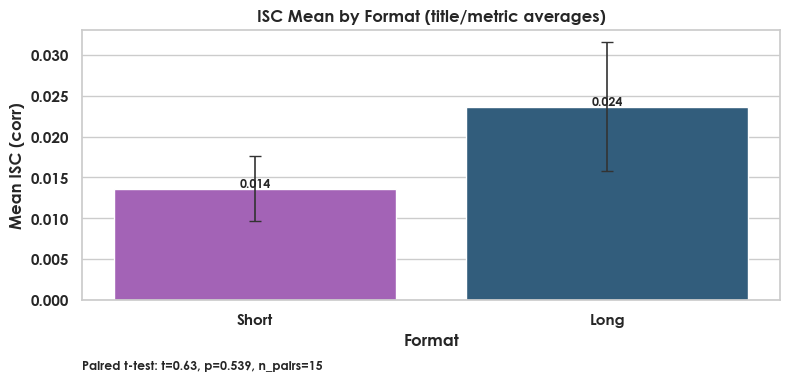

In [22]:
form_order = ["Short", "Long"]
curve_cache_path = CACHE_DIR / "isc_curves_by_title.parquet"
if "curve_stats" not in globals() or curve_stats.empty:
    if not curve_cache_path.exists():
        raise FileNotFoundError("Curve cache missing; run aggregation before running this cell.")
    curve_stats = pd.read_parquet(curve_cache_path)

# Restrict to formats of interest and aggregate at the title/metric level so both formats share a pairing.
form_curves = curve_stats.loc[curve_stats["form"].isin(form_order)].copy()
if form_curves.empty:
    print("No Long/Short ISC data available for comparison.")
else:
    aggregation_index = ["title", "metric"]
    title_metric_summary = (
        form_curves.groupby(aggregation_index + ["form"], dropna=False)
        .agg(
            mean_corr=("corr_mean", "mean"),
            window_count=("window_mid_seconds", "nunique"),
        )
        .reset_index()
    )
    paired_points = (
        title_metric_summary.pivot(
            index=aggregation_index,
            columns="form",
            values="mean_corr",
        )
        .dropna(subset=form_order)
        .reset_index()
    )
    if paired_points.empty:
        print("No title/metric combinations include both formats; cannot run the comparison.")
    else:
        t_stat, p_value = stats.ttest_rel(paired_points["Long"], paired_points["Short"])
        n_pairs = paired_points.shape[0]
        mean_diff = (paired_points["Long"] - paired_points["Short"]).mean()
        test_summary = pd.DataFrame(
            {
                "t_stat": [t_stat],
                "p_value": [p_value],
                "n_title_metric_pairs": [n_pairs],
                "mean_diff_long_minus_short": [mean_diff],
            }
        )
        display(test_summary)

        plotting_data = title_metric_summary.rename(columns={"mean_corr": "corr_mean"})
        form_summary = (
            plotting_data.groupby("form", observed=True)["corr_mean"]
            .agg(["mean", "count", "std"])
            .rename(columns={"mean": "mean_corr", "count": "n", "std": "std_corr"})
            .reset_index()
        )
        form_summary = (
            form_summary.set_index("form").reindex(form_order).dropna(subset=["mean_corr"]).reset_index()
        )
        form_summary["sem"] = form_summary["std_corr"] / np.sqrt(form_summary["n"].clip(lower=1))
        form_summary["ci95"] = form_summary["sem"] * 1.96
        display(form_summary[["form", "mean_corr", "ci95", "n"]])

        fig, ax = plt.subplots(figsize=(8, 4))
        sns.barplot(
            data=form_summary,
            x="form",
            y="mean_corr",
            order=form_order,
            palette=PALETTE,
            ax=ax,
        )
        ax.errorbar(
            x=range(len(form_summary)),
            y=form_summary["mean_corr"],
            yerr=form_summary["ci95"],
            fmt="none",
            ecolor="#333333",
            capsize=4,
            lw=1.2,
        )
        for idx, row in form_summary.iterrows():
            ax.text(
                idx,
                row["mean_corr"],
                f"{row['mean_corr']:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )
        ax.set_xlabel("Format")
        ax.set_ylabel("Mean ISC (corr)")
        ax.set_title("ISC Mean by Format (title/metric averages)")
        annotation = f"Paired t-test: t={t_stat:.2f}, p={p_value:.3g}, n_pairs={n_pairs}"
        ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
        plt.tight_layout()
        plt.show()

### Visualization Plan
- Apply a lightweight filter (e.g., minimum pair counts) so plotted curves reflect reliable overlap.
- Pivot `curve_stats` into tidy format and group by metric/title to support multi-panel overlays.
- Render Short vs Long traces with shared axes, matching the biometric color palette and annotating sample sizes.
- Save hooks (variables) so downstream cells can reuse the prepared plotting frame for bespoke figures if needed.

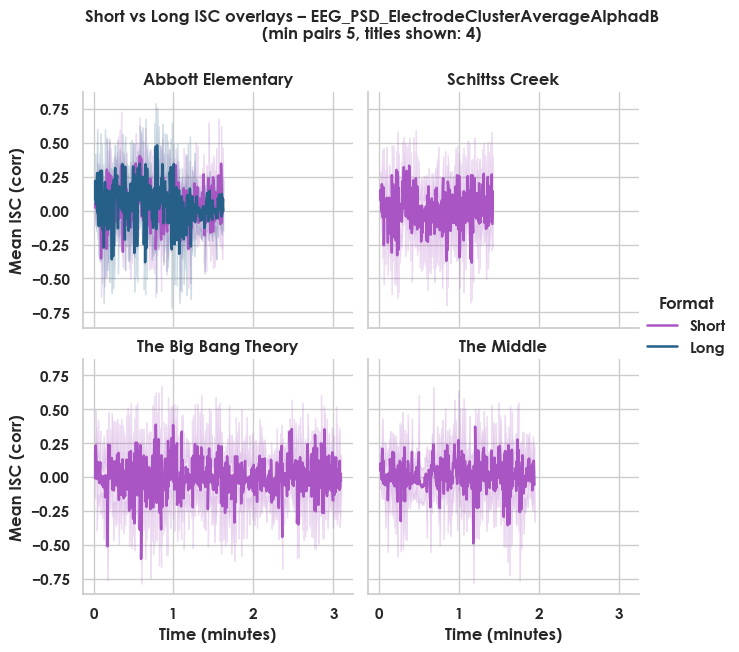

,title,form,mean_pair_count
0,Abbott Elementary,Long,30.047022
1,Abbott Elementary,Short,33.749288
2,Schittss Creek,Short,30.564972
3,The Big Bang Theory,Short,32.009901
4,The Middle,Short,39.302778


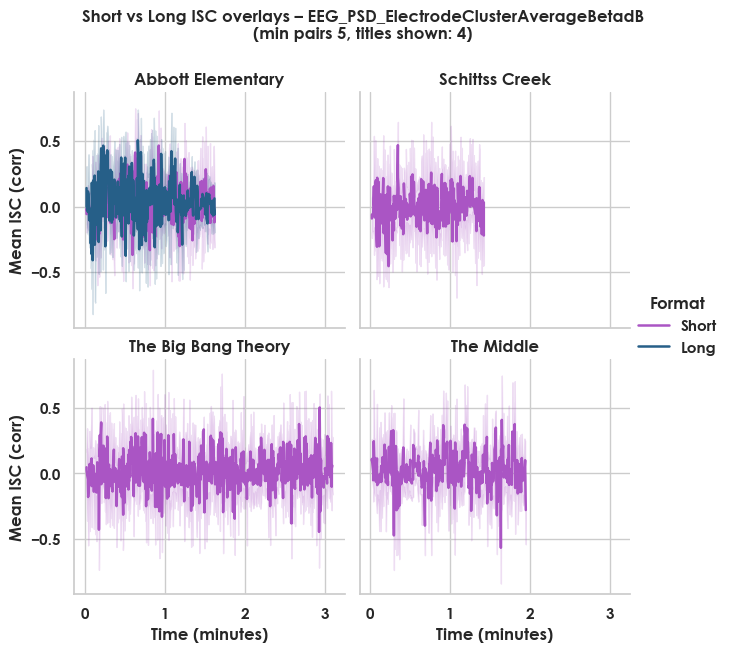

,title,form,mean_pair_count
0,Abbott Elementary,Long,30.047022
1,Abbott Elementary,Short,33.749288
2,Schittss Creek,Short,30.564972
3,The Big Bang Theory,Short,32.009901
4,The Middle,Short,39.302778


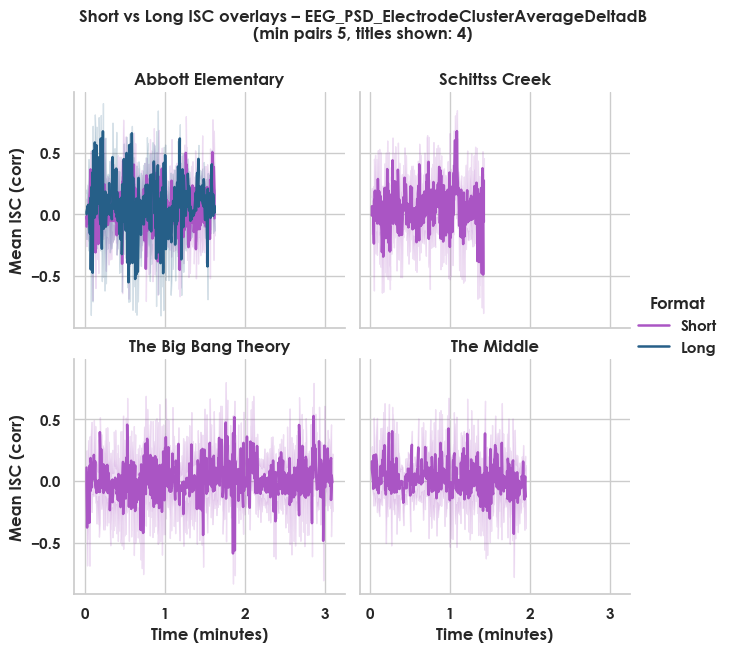

,title,form,mean_pair_count
0,Abbott Elementary,Long,30.047022
1,Abbott Elementary,Short,33.749288
2,Schittss Creek,Short,30.564972
3,The Big Bang Theory,Short,32.009901
4,The Middle,Short,39.302778


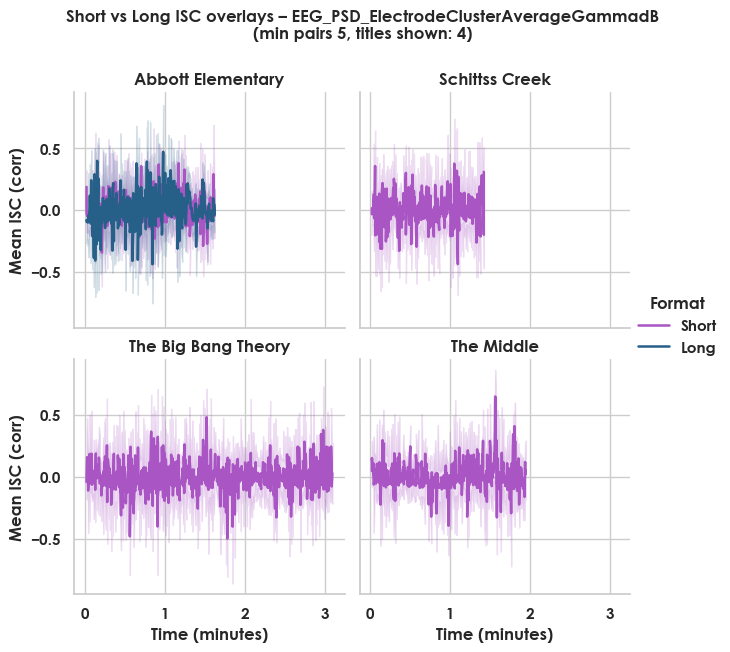

,title,form,mean_pair_count
0,Abbott Elementary,Long,30.047022
1,Abbott Elementary,Short,33.749288
2,Schittss Creek,Short,30.564972
3,The Big Bang Theory,Short,32.009901
4,The Middle,Short,39.302778


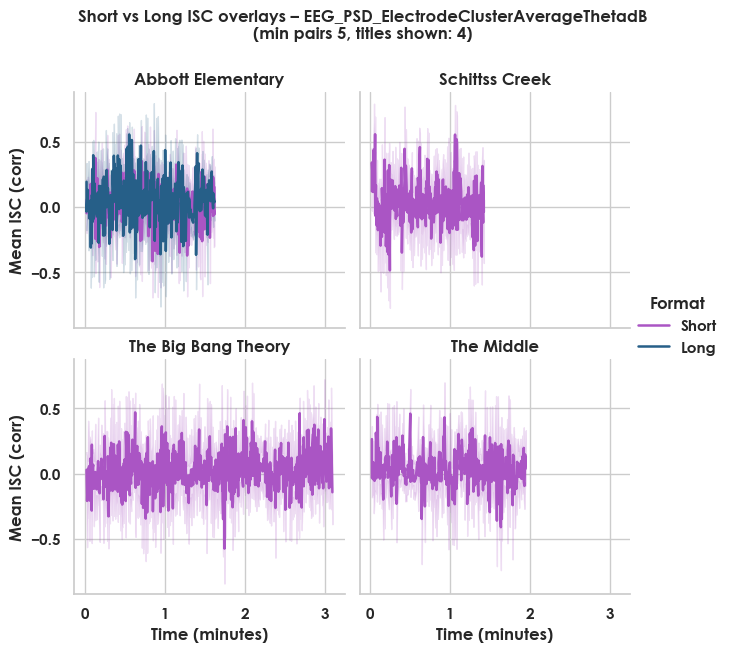

,title,form,mean_pair_count
0,Abbott Elementary,Long,30.047022
1,Abbott Elementary,Short,33.749288
2,Schittss Creek,Short,30.564972
3,The Big Bang Theory,Short,32.009901
4,The Middle,Short,39.302778


In [23]:
MIN_PAIR_COUNT = 5
MAX_TITLES_PER_METRIC = 4
METRICS_TO_PLOT = sorted(curve_stats["metric"].unique())

overlay_source = curve_stats.loc[curve_stats["pair_count"] >= MIN_PAIR_COUNT].copy()
if overlay_source.empty:
    print("No curve rows meet the minimum pair-count threshold; adjust MIN_PAIR_COUNT and rerun.")
else:
    overlay_source["time_minutes"] = overlay_source["window_mid_seconds"] / 60.0
    overlay_source = overlay_source.sort_values(
        ["metric", "title", "form", "time_minutes"]
    )

    def _plot_overlay(metric_frame: pd.DataFrame, metric_name: str) -> None:
        top_titles = (
            metric_frame.groupby("title")["pair_count"].mean().sort_values(ascending=False).head(MAX_TITLES_PER_METRIC).index
        )
        metric_focus = metric_frame[metric_frame["title"].isin(top_titles)]
        if metric_focus.empty:
            print(f"{metric_name}: no titles available after filtering; skipping plot.")
            return
        g = sns.FacetGrid(
            metric_focus,
            col="title",
            col_wrap=2,
            hue="form",
            hue_order=form_order,
            palette=PALETTE,
            height=3.2,
            sharey=True,
            sharex=True,
        )

        def _draw(data: pd.DataFrame, color: str, **kwargs):
            ax = plt.gca()
            form_label = data["form"].iloc[0] if not data.empty else ""
            ax.plot(
                data["time_minutes"],
                data["corr_mean"],
                color=color,
                label=form_label,
                linewidth=1.8,
            )
            ax.fill_between(
                data["time_minutes"],
                data["corr_mean"] - data["corr_ci95"],
                data["corr_mean"] + data["corr_ci95"],
                color=color,
                alpha=0.18,
            )

        g.map_dataframe(_draw)
        g.add_legend(title="Format")
        g.set_axis_labels("Time (minutes)", "Mean ISC (corr)")
        g.set_titles(col_template="{col_name}")
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(
            f"Short vs Long ISC overlays – {metric_name}\n(min pairs "+ str(MIN_PAIR_COUNT) + ", titles shown: " + str(len(metric_focus['title'].unique())) + ")",
            fontsize=12,
            fontweight="bold",
        )
        plt.show()

        summary = (
            metric_focus.groupby(["title", "form"])["pair_count"]
            .mean()
            .rename("mean_pair_count")
            .reset_index()
        )
        display(summary.sort_values(["title", "form"]))

    for metric_name in METRICS_TO_PLOT:
        metric_frame = overlay_source[overlay_source["metric"] == metric_name]
        if metric_frame.empty:
            continue
        _plot_overlay(metric_frame, metric_name)